# Playground

---

# How convolutions are actually performed under the hood

[Source](https://towardsdatascience.com/how-are-convolutions-actually-performed-under-the-hood-226523ce7fbf)

## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.util.shape import view_as_windows
torch.manual_seed(42);

## Style

In [2]:
sns.set_style("darkgrid")

## Utilities

In [3]:
def np2torch(x):
    """
    Convert numpy array to torch tensor
    """
    return torch.from_numpy(x.astype("float32"))

In [4]:
def im2col(x, kernel):
    """
    Image Block to Columns implementation
    """
    # Sanity checks
    assert len(kernel.shape) == 2, kernel.shape
    assert len(x.shape) == 2, x.shape
    # Infer shapes
    x_h, x_w = x.shape
    k_h, k_w = kernel.shape
    # Assuming Padding=0, Stride=1
    out_h, out_w = (x_h - k_h + 1, x_w - k_w + 1)
    
    rows = []
    
    for row in range(out_h):
        for col in range(out_w):
            window = x[row: row + k_h, col:col + k_w]
            rows.append(window.flatten())
            
    return np.array(rows).T

In [5]:
def memory_strided_im2col(x, kernel):
    """
    Memory strided Image Block to Columns implementation
    """
    # Sanity checks
    assert len(kernel.shape) == 2, kernel.shape
    assert len(x.shape) == 2, x.shape
    # Infer shapes
    x_h, x_w = x.shape
    k_h, k_w = kernel.shape
    # Assuming Padding=0, Stride=1
    out_h, out_w = (x_h - k_h + 1, x_w - k_w + 1)
    
    windows = view_as_windows(x, kernel.shape)
    return windows.reshape(k_h * k_w, out_h * out_w)

## Setup

In [6]:
def setup(xh=3, xw=3, kh=2, kw=2, seed=42):
    """Create convolution setup"""
    np.random.seed(seed)
    A = np.random.rand(xh, xw) # input matrix
    k = np.random.rand(kh, kw) # kernel 
    b = np.random.rand(1) # bias
    return A, k, b

In [7]:
def torch_setup(A, k, b):
    """
    torch setup
    """
    At = np2torch(A).unsqueeze(0).unsqueeze(0)
    kt = np2torch(k).unsqueeze(0).unsqueeze(0)
    bt = np2torch(b)
    return At, kt, bt

## Naive implementation

In [8]:
def naive_conv_2d(x, kernel, bias):
    """
    Conv2d naive implementation
    """
    # Sanity checks
    assert len(kernel.shape) == 2, kernel.shape
    assert len(x.shape) == 2, x.shape
    # Infer shapes
    x_h, x_w = x.shape
    k_h, k_w = kernel.shape
    # Assuming Padding=0, Stride=1
    out_h, out_w = (x_h - k_h + 1, x_w - k_w + 1)
    result = np.zeros((out_h, out_w))
    # Populate result using convolution
    for row in range(out_h):
        for col in range(out_w):
            window = x[row:row + k_h, col:col + k_w]
            result[row, col] = np.sum(kernel * window)
            
    return result + bias

## Torch implementation

In [9]:
def torch_conv_2d(x, kernel, bias):
    return F.conv2d(input=x, weight=kernel, bias=bias, stride=1, padding=0, dilation=1)

## Im2Col implementation

In [10]:
def im2col_conv_2d(x, kernel, bias):
    """
    Im2Col convolution implementation
    """
    im2col_matrix = im2col(x, kernel)
    
    # Infer shapes
    x_h, x_w = x.shape
    k_h, k_w = kernel.shape
    # Assuming Padding=0, Stride=1
    out_h, out_w = (x_h - k_h + 1, x_w - k_w + 1)
    
    im2col_conv = kernel.flatten().dot(im2col_matrix) + bias
    return im2col_conv.reshape(out_h, out_w)

## Memory strided Im2Col implementation

In [11]:
def memory_strided_im2col_conv_2d(x, kernel, bias):
    """
    Memory strided Im2Col convolution implementation
    """
    mem_strided_mat = memory_strided_im2col(x, kernel)
    
    # Infer shapes
    x_h, x_w = x.shape
    k_h, k_w = kernel.shape
    # Assuming Padding=0, Stride=1
    out_h, out_w = (x_h - k_h + 1, x_w - k_w + 1)
    
    mem_strided_conv = kernel.flatten().dot(mem_strided_mat) + bias
    return mem_strided_conv.reshape(out_h, out_w)

## Comparison

In [12]:
A, k, b = setup()

naive_conv_op = naive_conv_2d(A, k, b)
print(naive_conv_op)

[[1.207632   1.18176207]
 [1.41682216 1.66652925]]


In [13]:
At, kt, bt = torch_setup(A, k, b)

torch_conv_op = F.conv2d(input=At, weight=kt, bias=bt, stride=1, padding=0, dilation=1)
print(torch_conv_op)

tensor([[[[1.2076, 1.1818],
          [1.4168, 1.6665]]]])


In [14]:
%%timeit
naive_conv_2d(A, k, b)

83.6 µs ± 835 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%%timeit
torch_conv_2d(At, kt, bt)

The slowest run took 4.41 times longer than the fastest. This could mean that an intermediate result is being cached.
220 µs ± 115 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%timeit
im2col_conv_2d(A, k, b)

27.8 µs ± 334 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%%timeit
memory_strided_im2col_conv_2d(A, k, b)

109 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
def benchmark(ops, lower=3, upper=304, step=20, nruns=5):
    """
    Conv2d implementation comparison
    """
    # Sanity check
    assert ops in ["naive", "torch", "im2col", "memory_strided"], ops
    is_torch = ops == "torch"
    
    # Setup
    if ops == "naive":
        conv = naive_conv_2d
    elif is_torch:
        conv = torch_conv_2d
    elif ops == "im2col":
        conv = im2col_conv_2d
    elif ops == "memory_strided":
        conv = memory_strided_im2col_conv_2d
    
    # Main
    runs = []
    for _ in range(nruns):
        timers = []
        for n in range(lower, upper, step):
            A, k, b = setup(xh=n, xw=n)
            if is_torch:
                A, k, b = torch_setup(A, k, b)
            start = time()
            conv_res = conv(A, k, b)
            timers.append((n, time() - start))
    
        # Convert to np.arrays
        ns, times = map(np.array, zip(*timers))
        runs.append(times)
    return ns, np.mean(runs, axis=0)

In [19]:
n_naive, times_naive = benchmark("naive")
n_torch, times_torch = benchmark("torch")
n_im2col, times_im2col = benchmark("im2col")
n_mem_strided, times_mem_strided = benchmark("memory_strided")

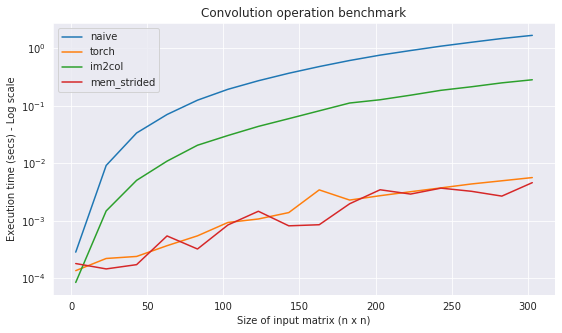

In [20]:
plt.figure(figsize=(9, 5))
plt.title("Convolution operation benchmark")
plt.plot(n_naive, times_naive, label="naive")
plt.plot(n_torch, times_torch, label="torch")
plt.plot(n_im2col, times_im2col, label="im2col")
plt.plot(n_mem_strided, times_mem_strided, label="mem_strided")
plt.ylabel("Execution time (secs) - Log scale")
plt.xlabel("Size of input matrix (n x n)")
plt.yscale("log")
plt.legend(frameon=True);